In [ ]:
# bellou

## My tasks 
1. Rename things 

## SECTION 1: Cluster Analysis

---
Loading the data in CSV format as Pandas DataFrame 
---
1. Clean the data by dropping Nan Values
2. Setting the date as index of the three dataframes
3. Selecting the relevant features we will consider 

In [91]:
# read the csv file containing the polluters 
df_pollution = pd.read_csv("./Project_3/data/data-project3/pollution_us_2000_2016.csv")
# read the csv file containing temperature data into a DataFrame
df_temp = pd.read_csv("./Project_3/data/data-project3/GlobalLandTemperaturesByCity.csv")
# reading the 
df_greenhouse = pd.read_csv("./Project_3/data/data-project3/greenhouse_gas_inventory_data_data(1).csv")

In [90]:
mask = df_greenhouse["country_or_area"] == "United States of America"
df_greenhosue[mask]

0       False
1       False
2       False
3       False
4       False
        ...  
8401     True
8402     True
8403     True
8404     True
8405     True
Name: country_or_area, Length: 8406, dtype: bool

In [74]:
# Droping the NaN values 
df_pollution.dropna(inplace=True)

df_temp.dropna(inplace=True)

df_greenhouse.dropna(inplace=True)

In [75]:
# Dropping duplicates 
df_pollution.drop_duplicates(subset=None, keep='first', inplace=True)
df_temp.drop_duplicates(subset=None, keep='first', inplace=True)
df_greenhouse.drop_duplicates(subset=None, keep='first', inplace=True)

In [76]:
# Setting the date as an index of the three dataframes 
df_pollution.set_index("Date Local", inplace=True)
df_temp.set_index("dt", inplace=True)
df_greenhouse.set_index("year", inplace=True)

In [77]:
# Changing the type of the index to dattime 
df_pollution.index = pd.to_datetime(df_pollution.index)
df_temp.index = pd.to_datetime(df_temp.index)
df_greenhouse.index = pd.to_datetime(df_greenhouse.index)

In [78]:
cutoff_date = pd.to_datetime("2000-01-01")
df_pollution = df_pollution[df_pollution.index >= cutoff_date]
df_temp = df_temp[df_temp.index >= cutoff_date]
df_greenhouse = df_greenhouse[df_greenhouse.index >= cutoff_date]

In [79]:
mask = df_temp["Country"] == "United States"
df_temp = df_temp[mask]

In [80]:
# Dropping two uncessary columns 
df_temp = df_temp.drop(["Country", "AverageTemperatureUncertainty"], axis=1)

In [81]:
df_pollution = df_pollution[["City","NO2 Mean", "O3 Mean", "SO2 Mean", "CO Mean"]]
# df_temp = df_temp[["AverageTemperature", "City", "Latitude", "Longitude"]]
df_greenhouse = df_greenhouse[["country_or_area", "value"]]

In [82]:
mask = df_greenhouse["country_or_area"] == "United States of America"
df_greenhouse = df_greenhouse[mask]

In [83]:
df_pollution.index = df_pollution.index.year
df_greenhosue.index = df_greenhosue.index.year
df_temp.index = df_temp.index.year

AttributeError: 'Index' object has no attribute 'year'

country_or_area    United States of America
value                            293.205663
Name: 1970, dtype: object

In [124]:
cutoff_date = pd.to_datetime("2000-01-01")
cutoff_date

Timestamp('2000-01-01 00:00:00')

In [125]:
df_pollution = df_pollution[df_pollution.index >= cutoff_date]
df_temp = df_temp[df_temp.index >= cutoff_date]
# df_greenhouse = df_greenhouse[df_greenhouse.index >= cutoff_date]

In [ ]:
df_temp

## SECTION : 

The aim of this section is to implement an **ARIMA** model to predict the temperature $T$ of a given city over a specified period of time $\Delta t$. The steps to followed to accomplish this task are :
1. Cleaning the data given in the `CSV` file `GlobalLandTemperaturesByCity.csv`
    - Removing `NaN` values 
    - Dropping the duplicates
    - Setting the `Date` value and an index to the `DataFrame` object
    - Selecting only the relevant features (i.e. columns): `Country-> USA`, `AverageTemperature`
    - Scaling the `AverageTemperature` to the interval $[0, 1]$
    - Averaging the data per year
2. Making the Time Series Stationary
    - Splitting the data into training and testing subsamples.
    - Perform seasonal decomposition of the training sample
    - Remove the seasonal and trends terms from the time series for all the cities
    - Checking the stationarity of the resulting time series using Augmented Dickey-Fuller Test statistic
3. Implementing the ARIMA model for all the cities
   - Fine tuning the model by finding the best parameters `p, q,` and `d`
   - Computing the Mean Square Error between the result of the forecast and the testing data 

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split # SPlit the data for training

from sklearn.preprocessing import MinMaxScaler # Scale the data 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 1. Cleaning the data

First, I cleaned the data by dropping the `NaN` values and the duplicate rows in the dataset. Then, I set the date column as an index of the DataFrame and changed its type to pandas datetime. Afterward, I only selected the country which will be studied by masking the DataFrame and dropping the irrelevant columns (i.e AverageTemperatureUncertainty, Country, Longitude, Latitude). Finally, I scaled the values of the average temperature to the interval $[0, 1]$ and resembled the data by years. All this steps are refactored in the function `clean_data(df)` which returns a clean time series. 

In [11]:
def clean_data(df, period):
    if not period in ["YE", "ME"]:
        return "Option not supported, please use either YE or ME"
    # Then we clean the data by first removing the NaN values
    df = df.dropna()
    # The droping duplicates 
    df = df.drop_duplicates(subset=None, keep='first')
    # Setting the data as index 
    # Now we set the data as an index 
    df.set_index("dt", inplace=True)
    # After that we set the type for the index to be datetime 
    df.index = pd.to_datetime(df.index)
    mask = df["Country"] == "United States" # Creating a mask that seclects the US from the data 
    df = df[mask] # applying the mask to the dataframe 
    df = df.drop(["AverageTemperatureUncertainty", "Country", "Longitude", "Latitude"], axis=1)
    # Saving the average temperature temporarily in variable 
    temp_vals = df["AverageTemperature"].values.reshape(-1, 1)
    scaler = MinMaxScaler() # Calling the scaler to map the data to the interval [0, 1] 
    scaled_temp = scaler.fit_transform(temp_vals) # Scale the data 
    df["AverageTemperature"] = scaled_temp # Assign the scaled values to their dataframe 
    # df = df.groupby(["City"]).resample("YE").mean() # Grouping the values by city and averaging the 
                                                    # Temperature per year
    df = df.groupby(["City"]).resample(period).mean() # Grouping the values by city and averaging the 
    
    df = df.dropna()    # Droping the NaN values
    return df

In [17]:
# Reading the temperature data 
temp_data_path = "./Project_3/data/data-project3/GlobalLandTemperaturesByCity.csv.zip"
df_or = pd.read_csv(temp_data_path) # Original dataframe 

In [18]:
# Performing data cleaning 
df = clean_data(df_or, "ME")

In [19]:
df.to_csv("./section3_clean_data.csv")

To visulize the time series for some cities I randomly selected $16$ out $248$ available cities

In [20]:
city_names = np.array([x[0] for x in df.index])
city_names = np.unique(city_names, return_counts=False)
# Seclecting 4 random cities from the dataset 
np.random.seed(42)
rd_cities = np.random.choice(city_names, 16, replace=False)
rd_cities

array(['Charleston', 'Anaheim', 'Riverside', 'Greensboro', 'Orange',
       'Worcester', 'San Diego', 'Jersey City', 'Antioch', 'Warren',
       'Virginia Beach', 'Washington', 'West Covina', 'Reno',
       'Evansville', 'Overland Park'], dtype='<U17')

## Visulizing the change in average temperature for 16 US cities asa fucntion of time 

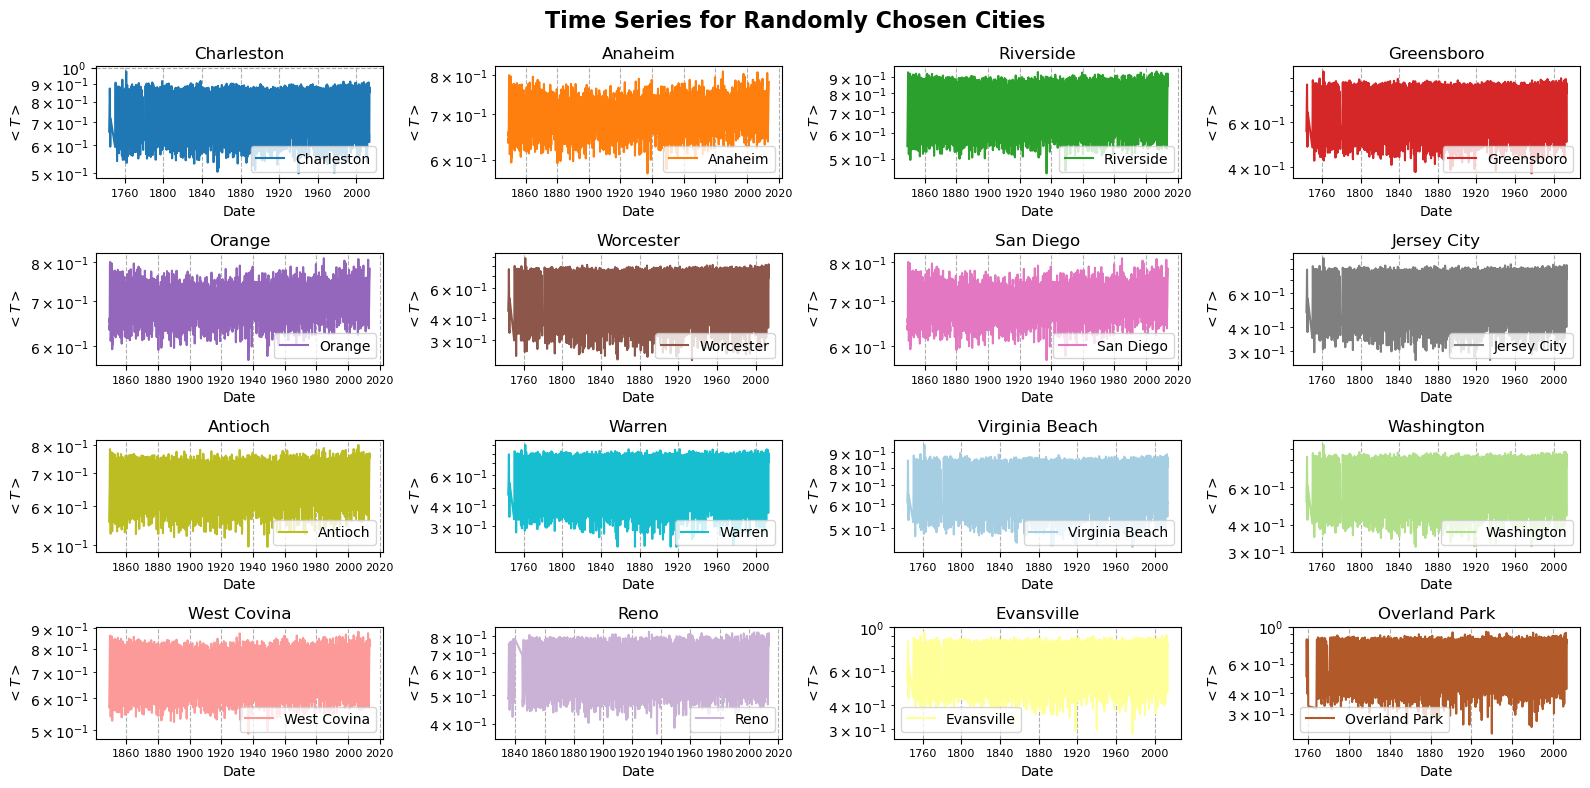

In [24]:
# In this cell I am plotting the different time series for 4 randomly choosen cities from the availbale data
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16, 8))
ax = ax.flatten() # Flatten the 2x2 axes array to a 1D array
# colors = ['red', 'blue', 'green', 'orange']  # Or any other colors you prefer
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#a6cee3',  # light blue
    '#b2df8a',  # light green
    '#fb9a99',  # light red
    '#cab2d6',  # light purple
    '#ffff99',  # light yellow
    '#b15928'   # dark orange-brown
]
for i, name in enumerate(rd_cities):
    data = df.loc[name]
    ax[i].plot(data.index, data["AverageTemperature"], color=colors[i], label=f"{name}") # Plot on the i-th subplot
    ax[i].set_title(name) # Add title for each city
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel(r"$<T>$")
    ax[i].legend(loc="best")
    ax[i].tick_params(axis='x', labelsize=8)
    ax[i].set_yscale("log")
    # ax[i].set_yticks(np.linspace(0, 1, 5))
    ax[i].grid(axis="both", ls="--")
fig.suptitle("Time Series for Randomly Chosen Cities", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("./section3_figures/section3_time_series_me.png")
plt.show()

In [25]:
df_yearly = clean_data(df_or, "YE")

# Splitting the data into training and testing 
Then I split the data into training and test sets. $70%$ of the data was used for training, while the $30%$ left was used for testing

In [27]:
# Creating a dictionary with the city names as keys and the corresponding dataframe as a value of the dictionary 
data = {}
for name in city_names:
    data[f"{name}"] = df.loc[name]

In [28]:
# Splitting the data into training and testing 
train_data = {} # Dictionary for the training data per city 
test_data = {} # Dictionary for the testing data per city 

for key, value in data.items():
    # Getting the feature of the data 
    temp_var = data[key] 
    X = temp_var.index 

    # Getting the target of the data
    y = temp_var["AverageTemperature"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
    # Assigning the feature and target to the training data 
    train_df = pd.DataFrame({"AverageTemperature": y_train}, index=X_train)
    train_data[key] = train_df

    # Assigning the feature and target to the testing data
    test_df = pd.DataFrame({"AverageTemperature": y_test}, index=X_test)
    test_data[key] = test_df

In [82]:
print(f"The size of the testing data points is: {len(test_df)}")
print(f"The size of the training data points is: {len(train_df)}")

The size of the testing data points is: 936
The size of the training data points is: 2183


# Making the time series stationary

Then I made the time series stationary by removing the trends and seasonal contributions. 

In [29]:
# additive_decomposition = STL(endog=df.loc["Abilene"], robust=True, period=12).fit()

# Iterate over the training dataset 
# Decompose the target values
# Save the dates as pandas datetime 
train_data_stationary = {} # Dictionary to save the stationary time series 
# List to save the stationariyt test results in 
adf_result = []
for key, value in train_data.items():
    # Get the dates 
    temp_var = train_data[key] # Use a temporary variable to save the subdataframe 
    # Dates that will be used as an index for the subdataframes 
    X = temp_var.index
    # Get the target values of the time series 
    y = temp_var["AverageTemperature"]
    # Reshape the target 
    y = y.to_numpy().reshape(-1, 1)

    # Apply seasonal decomposition 
    seasonal_decomposition = STL(endog=y, robust=True, period=12).fit() 
    trend = seasonal_decomposition.trend.reshape(-1, 1)
    seasonal = seasonal_decomposition.seasonal.reshape(-1, 1)
    # Remove the seasonal and trends
    y = y - trend - seasonal
    y = y.flatten()
    temp_result = adfuller(y)
    adf_result.append(temp_result)
    temp_df = pd.DataFrame({"AverageTemperature": y}, index=X)    

    # Add the city to the dictionary 

    train_data_stationary[key] = temp_df

Then, I checked for stationarity of the resulting time series 

In [30]:
# Checking for stationarity of the data 
def check_stationarity(series):
    result = adfuller(series)
    # print("ADF Statistic:", result[0])
    # print("p-value:", result[1])
    return result[1] > 0.05, result[1]  # If True, series is non-stationary
count = 0 # Counter for non-stationary time series   
for key, value in train_data_stationary.items(): 
    data = train_data_stationary[key]
    X = data["AverageTemperature"]
    # print(f"Statistics for {key}")
    # print(f"{30 * "--"}")
    check, p_val = check_stationarity(X)
    if check:
        count += 1
        print(key)
        print(p_val)
    # print("\n")
print(f"The are {count} Time series that are non-stationary")

The are 0 Time series that are non-stationary


## Visulizing Stationary Time Series 

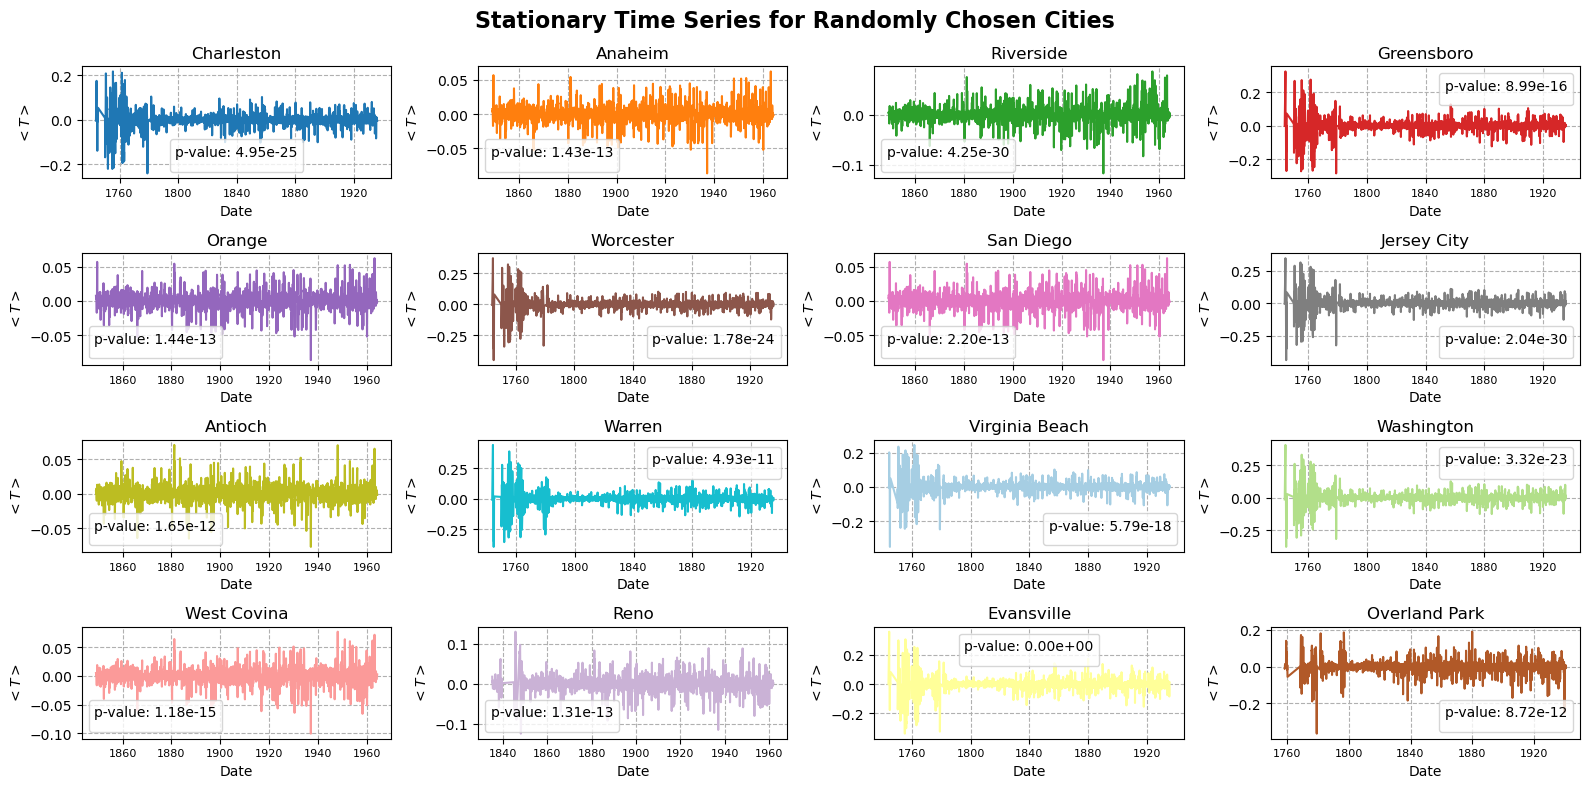

In [31]:
# In this cell I am plotting the different time series for 4 randomly choosen cities from the availbale data
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16, 8))
ax = ax.flatten() # Flatten the 2x2 axes array to a 1D array
# colors = ['red', 'blue', 'green', 'orange']  # Or any other colors you prefer
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#a6cee3',  # light blue
    '#b2df8a',  # light green
    '#fb9a99',  # light red
    '#cab2d6',  # light purple
    '#ffff99',  # light yellow
    '#b15928'   # dark orange-brown
]
for i, name in enumerate(rd_cities):
    data = train_data_stationary[name]
    ax[i].plot(data.index, data["AverageTemperature"], color=colors[i]) # Plot on the i-th subplot
    ax[i].set_title(name) # Add title for each city
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel(r"$<T>$")
    ax[i].legend(loc="best", title=f"p-value: {adf_result[i][1]:.2e}")
    ax[i].tick_params(axis='x', labelsize=8)
    ax[i].grid(axis="both", ls="--")
fig.suptitle("Stationary Time Series for Randomly Chosen Cities", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("./section3_figures/section3_stat_TS.png")
plt.show()

## Implementing the ARIMA model for weather forcasting

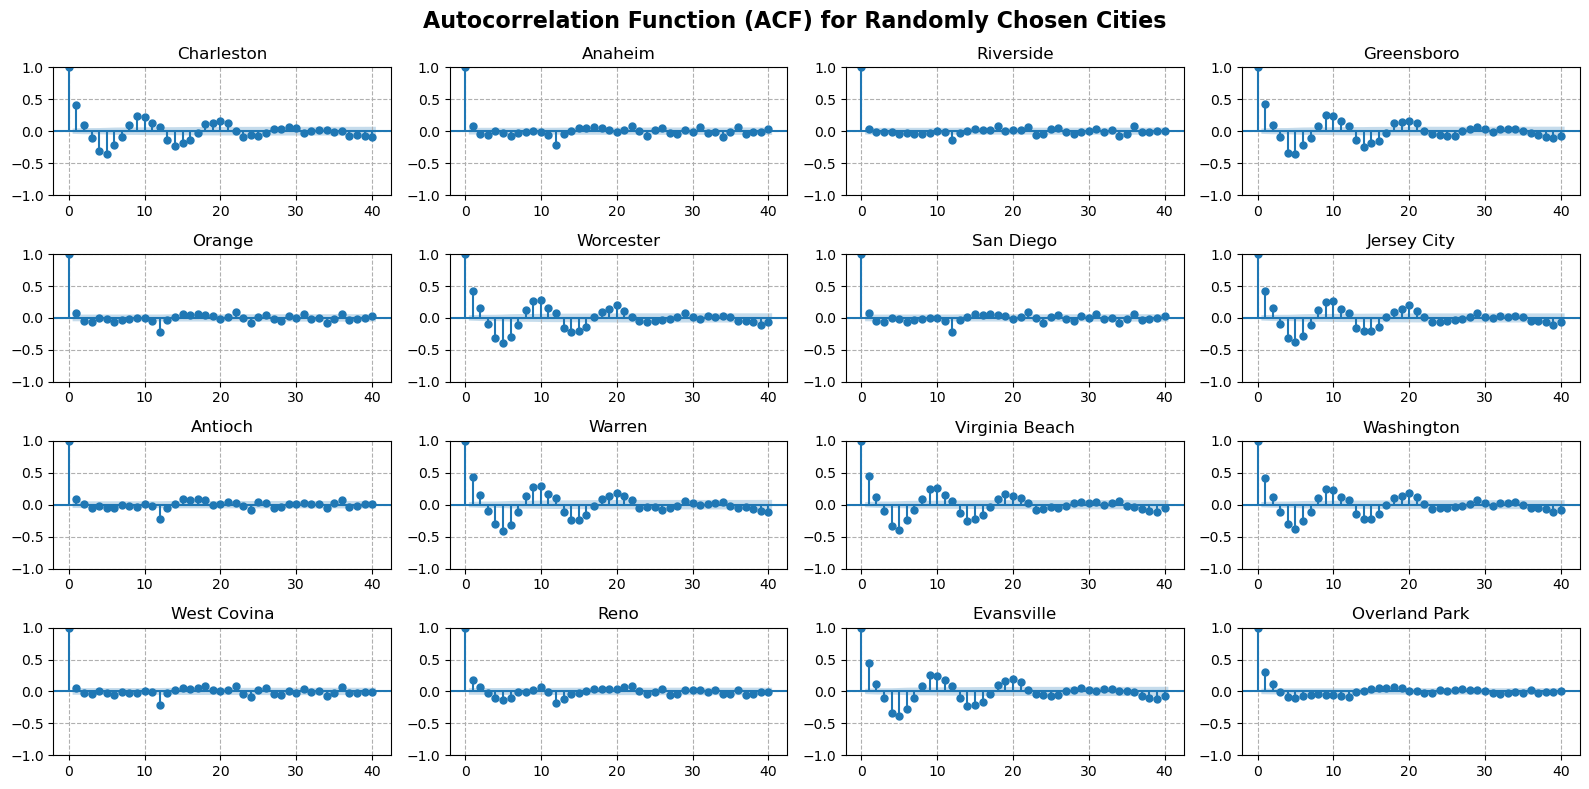

In [37]:
# In this cell I am plotting the different time series for 4 randomly choosen cities from the availbale data
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16, 8))
ax = ax.flatten() # Flatten the 2x2 axes array to a 1D array
# colors = ['red', 'blue', 'green', 'orange']  # Or any other colors you prefer
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#a6cee3',  # light blue
    '#b2df8a',  # light green
    '#fb9a99',  # light red
    '#cab2d6',  # light purple
    '#ffff99',  # light yellow
    '#b15928'   # dark orange-brown
]
for i, name in enumerate(rd_cities):
    data = train_data_stationary[name]
    plot_acf(data["AverageTemperature"], lags=40, ax=ax[i])
    ax[i].set_title(f"{name}") # Add title for each city
    ax[i].grid(axis="both", ls="--")
fig.suptitle("Autocorrelation Function (ACF) for Randomly Chosen Cities", fontsize=16, fontweight="bold")
plt.savefig("./section3_figures/section3_acf.png")
plt.tight_layout()
plt.show()

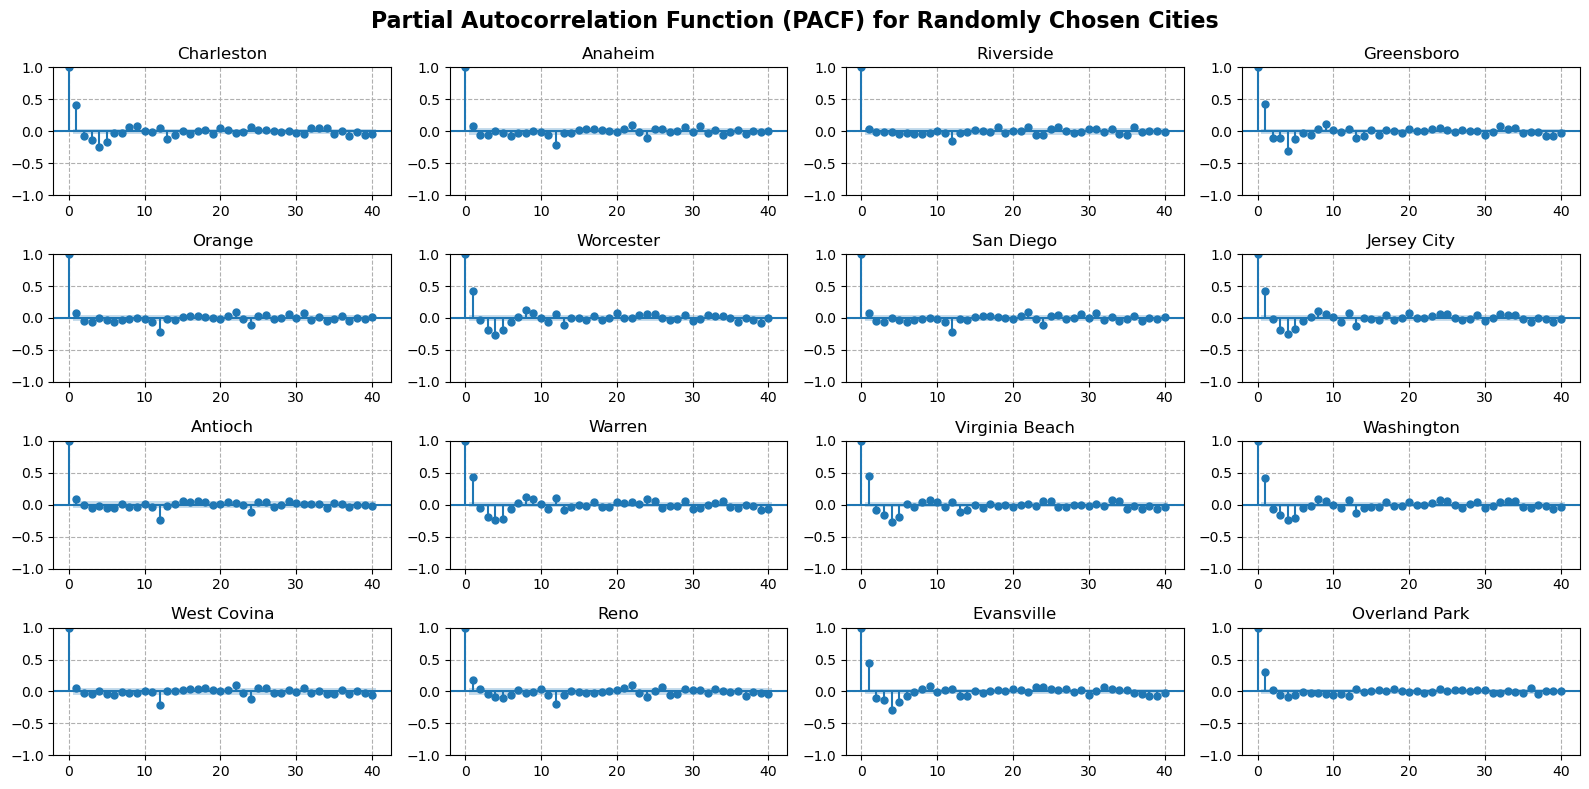

In [39]:
# In this cell I am plotting the different time series for 4 randomly choosen cities from the availbale data
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16, 8))
ax = ax.flatten() # Flatten the 2x2 axes array to a 1D array
# colors = ['red', 'blue', 'green', 'orange']  # Or any other colors you prefer
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#a6cee3',  # light blue
    '#b2df8a',  # light green
    '#fb9a99',  # light red
    '#cab2d6',  # light purple
    '#ffff99',  # light yellow
    '#b15928'   # dark orange-brown
]
# fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16, 8))
for i, name in enumerate(rd_cities):
    data = train_data_stationary[name]
    plot_pacf(data["AverageTemperature"], lags=40, ax=ax[i])
    # ax[i].plot(data.index, data["AverageTemperature"], color=colors[i]) # Plot on the i-th subplot
    ax[i].set_title(f"{name}") # Add title for each city
    ax[i].grid(axis="both", ls="--")
fig.suptitle("Partial Autocorrelation Function (PACF) for Randomly Chosen Cities", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig("./section3_figures/section3_pcaf.png")
plt.show()
plt.close()

##SECTION 3: ARIMA model for temperature forecasting

In [40]:
p_range = q_range = list(range(0, 5))  

for i, name in enumerate(rd_cities):
    city_df = train_data_stationary[name]
    city_df_test = test_data[name]
    aic_values = []
    bic_values = []
    pq_values = []
    
    d = 0  # Differencing order
    
    for p in p_range:
        for q in q_range:
            try:
                # Fit ARIMA model
                model = ARIMA(city_df["AverageTemperature"], order=(p, d, q))
                results = model.fit()
                
                # Store AIC, BIC, and (p, q)
                aic_values.append(results.aic)
                bic_values.append(results.bic)
                pq_values.append((p, q))
            
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed: {e}")  # Print error for debugging
    
    # Find (p, q) with lowest AIC
    if aic_values:  # Ensure there are valid models
        best_pq = pq_values[np.argmin(aic_values)]
        print(f"City: {name}")
        # print(f"(p,q) corresponding to lowest AIC score: {best_pq}")
        # predictions = arima_model.predict(start=len(city_df), end=len(city_df)+len(city_df_test)-1)
        predictions = results.forecast(steps=len(city_df_test))
        mse = mean_squared_error(predictions, city_df_test["AverageTemperature"])
        # print(results.summary())
        print(f"MSE: {mse}")
        print(f"AIC: {results.aic}")
        print(f"BIC: {results.bic} \n")
    else:
        print("No valid ARIMA models found.")


City: Charleston
MSE: 0.5622756346213317
AIC: -9432.325608934609
BIC: -9375.441055369109 

City: Anaheim
MSE: 0.4920469770666433
AIC: -7953.6415658189035
BIC: -7901.321462502256 

City: Riverside
MSE: 0.5267206090991396
AIC: -7133.869464238286
BIC: -7081.549360921638 

City: Greensboro
MSE: 0.470284270181393
AIC: -8656.834757022862
BIC: -8599.950203457362 

City: Orange
MSE: 0.4920469770666433
AIC: -7953.6415658189035
BIC: -7901.321462502256 

City: Worcester
MSE: 0.33836140644110707
AIC: -8018.82260563682
BIC: -7961.938052071321 

City: San Diego
MSE: 0.4920469770666433
AIC: -7953.6415658189035
BIC: -7901.321462502256 

City: Jersey City
MSE: 0.37683853430705483
AIC: -8069.0784699282285
BIC: -8012.193916362729 

City: Antioch
MSE: 0.4559248345679834
AIC: -7974.190833943825
BIC: -7921.870730627177 

City: Warren
MSE: 0.35970938932245566
AIC: -7727.246836758263
BIC: -7670.293805408628 

City: Virginia Beach
MSE: 0.49530262113523976
AIC: -9166.924595341326
BIC: -9110.040041775826 

City:

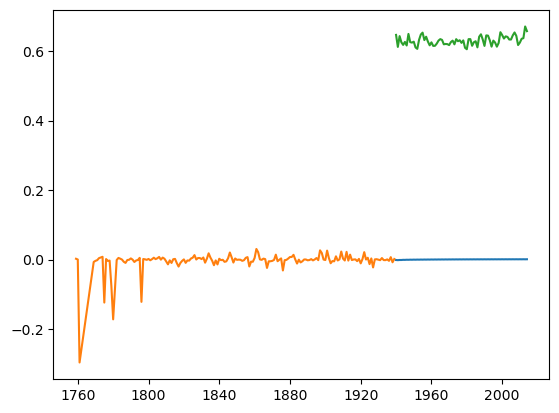

In [50]:
plt.plot(city_df_test.index, predictions)
plt.plot(city_df.index, city_df["AverageTemperature"])
plt.plot(city_df_test.index, city_df_test["AverageTemperature"])